## Write an Algorithm for Landmark Classification using transfer learning


### Transfer learning

In the previous notebook we have trained our own CNN, and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.


##  Step 0: Setting up

The following cells make sure that the environment is setup correctly and check that the GPU is available and ready to go.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (at least 2 Gb of hard drive)
setup_env()


##  Step 1: Create transfer learning architecture

In [3]:
!pytest -vv transfer.py

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: anyio-3.7.1
collected 1 item                                                                                   

transfer.py::test_get_model_transfer_learning PASSED                                         [100%]

========================================= warnings summary =========================================
transfer.py::test_get_model_transfer_learning
  /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
    warnings.warn(

transfer.py::test_get_model_transfer_learning
  /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` f


##  Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [4]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting
momentum = 0.9     # momentum for SGD

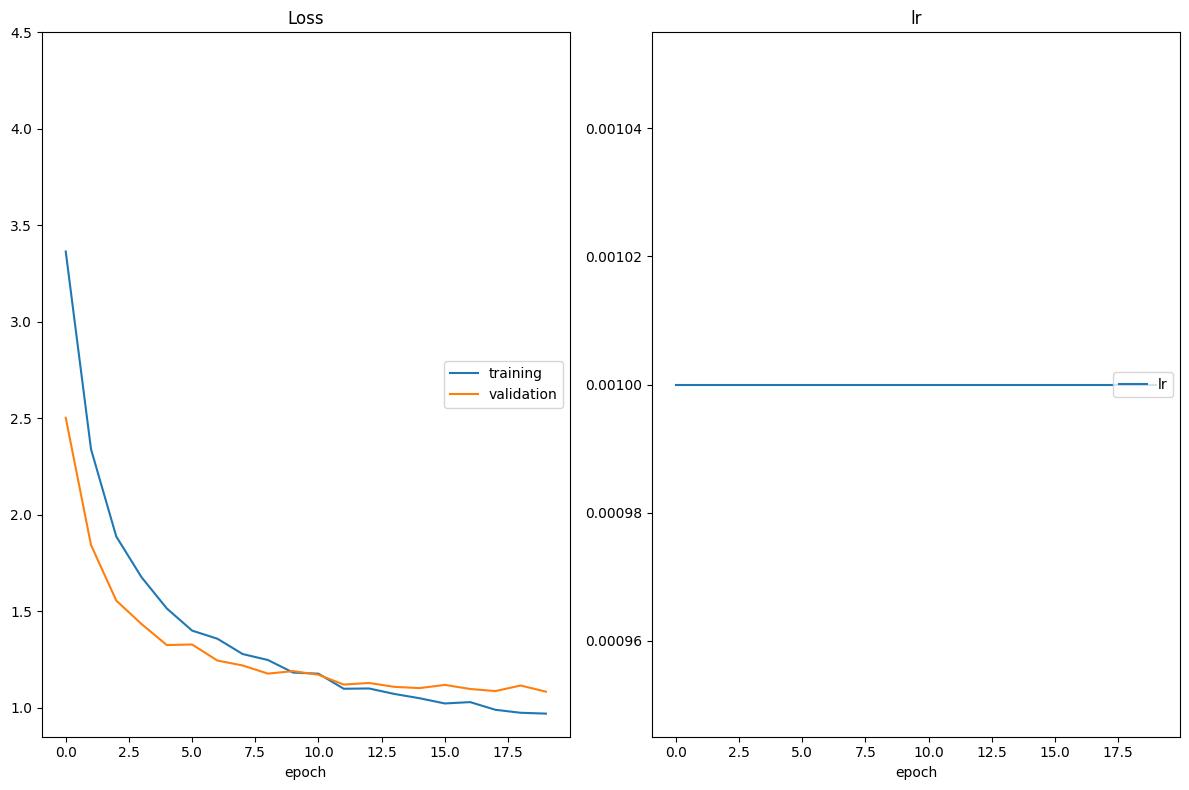

Training:   6%|██▏                               | 4/63 [00:02<00:40,  1.45it/s]


KeyboardInterrupt: 

In [5]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning.
# We use "resnet18" (ResNet 18)
# More models: https://pytorch.org/vision/0.10/models.html

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
    momentum=momentum
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

I decided to use ResNet18 for the base of my model, since it performs fairly well on ImageNet and is not too large of a model.  
Also, since ResNet18 was trained for the ImageNet task, it is a good model to use for this landmark classificaiton task, since both ImageNet and this landmark task use images of natural scenes.  
Additionally, I decided to use the same hyperparameters as in the previous notebook, since they worked well for the CNN model. I used the Adam optimizer, since it is a good optimizer for most tasks, and it is less sensitive to hyperparameters than SGD. I also used a learning rate of 0.001, since it is a good starting point for most tasks.


##  Step 3: Test the Model

In [14]:
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("test")

INFO:root:test


In [15]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)

# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]
INFO:root:Test Loss: 0.983113

INFO:root:
Test Accuracy: 73% (919/1250)


0.983112797141075


##  Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [7]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

100%|███████████████████████████████████████| 1250/1250 [01:51<00:00, 11.25it/s]


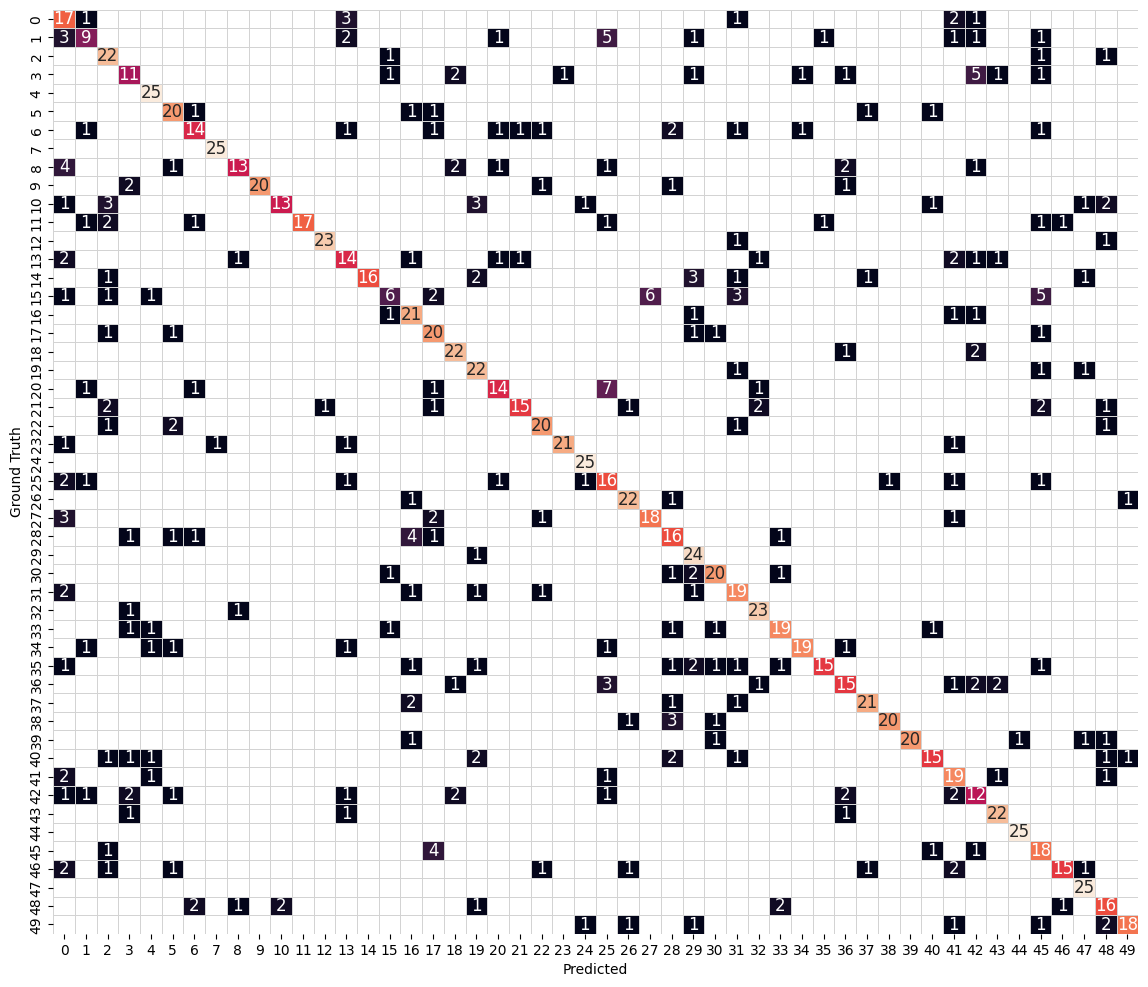

In [10]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)